In [24]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

In [25]:
file = "/content/Dataset.txt"

with open(file) as f:
    data_in_file = f.read()

data = data_in_file.lower().split("\n")

In [26]:
#Print first 5 lines
for i in range(5):
  print(data[i])

thy youth's proud livery, so gazed on now,
will be a tatter'd weed, of small worth held:
then being ask'd where all thy beauty lies,
where all the treasure of thy lusty days,
to say, within thine own deep-sunken eyes,


In [27]:
#Initialize the tokenizer and build vocabulary

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)
total_words = len(tokenizer.word_index) + 1  #Number of unique words in the data

In [28]:
print(f"Total words: {total_words}")

Total words: 3211


In [29]:
#Check one example by using tokenizing and reverse tokenizing

tokenize_line_1 = tokenizer.texts_to_sequences([data[0]])
print(f"Tokenized line 1: {tokenize_line_1}")
recover_line_1 = tokenizer.sequences_to_texts(tokenize_line_1)
print(f"Recovered line 1: {recover_line_1}")

Tokenized line 1: [[9, 1372, 179, 1373, 20, 1374, 35, 61]]
Recovered line 1: ["thy youth's proud livery so gazed on now"]


In [30]:
print(f"The token ID for 'Whose' is: {tokenizer.texts_to_sequences(['Whose'])}")

The token ID for 'Whose' is: [[129]]


In [31]:
#Function for generate sequences usign corpous
def sequence_generator(data):
    input_sequences = []

    for line in data:
      tokenized_line = tokenizer.texts_to_sequences([line])[0]

      for i in range(1, len(tokenized_line)):
          n_gram_sequence = tokenized_line[:i+1]
          input_sequences.append(n_gram_sequence)

    return input_sequences

In [32]:
#Test with first line of the data
first_example = sequence_generator([data[0]])

first_example

[[9, 1372],
 [9, 1372, 179],
 [9, 1372, 179, 1373],
 [9, 1372, 179, 1373, 20],
 [9, 1372, 179, 1373, 20, 1374],
 [9, 1372, 179, 1373, 20, 1374, 35],
 [9, 1372, 179, 1373, 20, 1374, 35, 61]]

In [33]:
#Convert while data into sequences using sequence_generator function
input_sequences = sequence_generator(data)

In [34]:
#max_sequence_len is used for padding sequences

max_sequence_len = max([len(x) for x in input_sequences])
print(f"maximum length of sequences is: {max_sequence_len}")

maximum length of sequences is: 11


In [35]:
def pad_seqs(input_sequences, maxlen):
    padded_sequences = pad_sequences(input_sequences, maxlen=maxlen, padding='pre')

    return padded_sequences

In [36]:
#Test first line of the text file
first_padded_sequence = pad_seqs(first_example, max([len(x) for x in first_example]))
first_padded_sequence

array([[   0,    0,    0,    0,    0,    0,    9, 1372],
       [   0,    0,    0,    0,    0,    9, 1372,  179],
       [   0,    0,    0,    0,    9, 1372,  179, 1373],
       [   0,    0,    0,    9, 1372,  179, 1373,   20],
       [   0,    0,    9, 1372,  179, 1373,   20, 1374],
       [   0,    9, 1372,  179, 1373,   20, 1374,   35],
       [   9, 1372,  179, 1373,   20, 1374,   35,   61]], dtype=int32)

In [37]:
# Pad the whole data
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"Shape of input sequences: {input_sequences.shape}")

Shape of input sequences: (15462, 11)


In [38]:
def X_and_Y_labels(input_sequences, total_words):

    #x_values
    X_labels = np.array(input_sequences)[:, :-1]

    # Extract labels (last word of each sequence) for y_values
    y_labels = np.array(input_sequences)[:, -1]

    #Convert to one hot encoding fot each word in Y pair for training model
    Y_labels = tf.keras.utils.to_categorical(y_labels, num_classes=total_words) #Convert to one hot encoding

    return X_labels, Y_labels

In [39]:
# Test your function with the padded n_grams_seq of the first example
first_X_labels, first_Y_labels = X_and_Y_labels(first_padded_sequence, total_words)

print(f"X label shape: {first_X_labels.shape}")
print(f"Y label shape: {first_Y_labels.shape}")
print("\nX_labels:\n")
print(first_X_labels)
print("\nY_labels:\n")
print(first_Y_labels)


X label shape: (7, 7)
Y label shape: (7, 3211)

X_labels:

[[   0    0    0    0    0    0    9]
 [   0    0    0    0    0    9 1372]
 [   0    0    0    0    9 1372  179]
 [   0    0    0    9 1372  179 1373]
 [   0    0    9 1372  179 1373   20]
 [   0    9 1372  179 1373   20 1374]
 [   9 1372  179 1373   20 1374   35]]

Y_labels:

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [40]:
#Generate X and Y labels for whole the data in the text file
X_Values, Y_Values = X_and_Y_labels(input_sequences, total_words)

print(f"features have shape: {X_Values.shape}")
print(f"labels have shape: {Y_Values.shape}")

features have shape: (15462, 10)
labels have shape: (15462, 3211)


In [44]:
def create_model(total_words, max_sequence_len):
    model = Sequential()
    model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [45]:
model = create_model(total_words, max_sequence_len)

history = model.fit(X_Values, Y_Values, epochs=50, verbose=2)

Epoch 1/50
484/484 - 12s - loss: 6.8946 - accuracy: 0.0217 - 12s/epoch - 25ms/step
Epoch 2/50
484/484 - 4s - loss: 6.4519 - accuracy: 0.0306 - 4s/epoch - 8ms/step
Epoch 3/50
484/484 - 3s - loss: 6.2149 - accuracy: 0.0394 - 3s/epoch - 7ms/step
Epoch 4/50
484/484 - 4s - loss: 5.9633 - accuracy: 0.0479 - 4s/epoch - 9ms/step
Epoch 5/50
484/484 - 3s - loss: 5.6776 - accuracy: 0.0592 - 3s/epoch - 7ms/step
Epoch 6/50
484/484 - 3s - loss: 5.3430 - accuracy: 0.0753 - 3s/epoch - 7ms/step
Epoch 7/50
484/484 - 4s - loss: 4.9842 - accuracy: 0.0909 - 4s/epoch - 7ms/step
Epoch 8/50
484/484 - 4s - loss: 4.6022 - accuracy: 0.1173 - 4s/epoch - 8ms/step
Epoch 9/50
484/484 - 3s - loss: 4.2296 - accuracy: 0.1545 - 3s/epoch - 7ms/step
Epoch 10/50
484/484 - 3s - loss: 3.8588 - accuracy: 0.2124 - 3s/epoch - 6ms/step
Epoch 11/50
484/484 - 4s - loss: 3.5142 - accuracy: 0.2730 - 4s/epoch - 8ms/step
Epoch 12/50
484/484 - 3s - loss: 3.1941 - accuracy: 0.3324 - 3s/epoch - 7ms/step
Epoch 13/50
484/484 - 3s - loss: 2

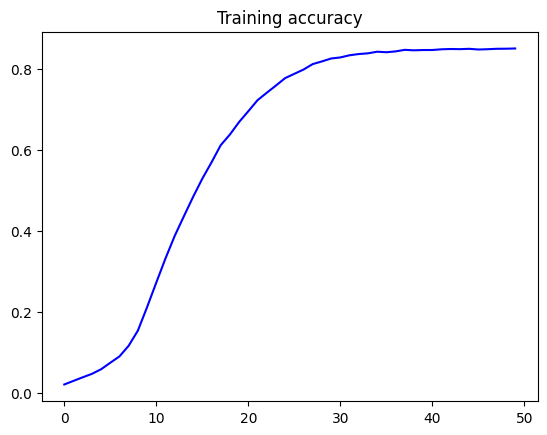

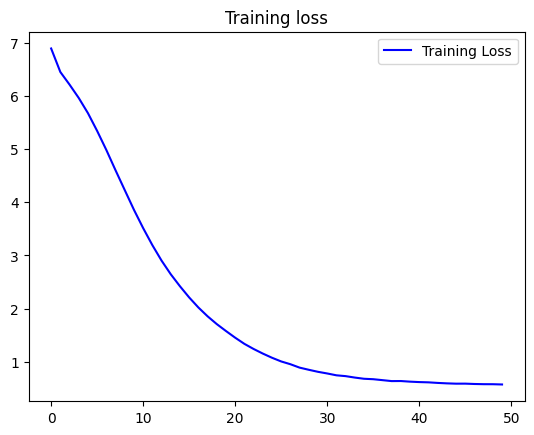

In [46]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [51]:
testing_text = "Unthrifty loveliness, why dost thou spend"
next_words = 50

for _ in range(next_words):
    # Convert the text into sequences
    token_list = tokenizer.texts_to_sequences([testing_text])[0]

    # Pad the sequences
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

    # Get the probabilities of predicting a word
    predicted = model.predict(token_list, verbose=0)

    # Choose the next word based on the maximum probability
    predicted = np.argmax(predicted, axis=-1).item()

    # Get the actual word from the word index
    output_word = tokenizer.index_word[predicted]

    # Append to the current text
    testing_text += " " + output_word

print(testing_text)

Unthrifty loveliness, why dost thou spend spend mine mine eyes prove thee is not heart new had new 'will ' bright worse prove new care in thine eyes seeing rare ill had well knows well knows thee still green thee back doth alone find to be gone new bright worth so behold ' level in me
